# Visualizing the mouse behavior

In [4]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import tree as Tree
import sklearn.tree
import sys
import os
%matplotlib inline 

## load in csv files (from running exportTrials.m)

In [80]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/new_master_8020_df.csv',index_col=0)

In [6]:
data.head(2)

,Mouse ID,Session ID,Block Trial,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,10_trialDuration,9_Port,...,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision,Switch,Higher p port,Reward
0,dumble,70716,11.0,10.0,-1.0,1.0,1.0,1.801,0.439,1.0,...,0.325,1.0,0.0,2.133,0.482,1.411,1.0,0.0,1.0,0.0
1,dumble,70716,12.0,10.0,-2.0,1.0,1.0,1.828,0.353,1.0,...,0.482,1.0,0.0,1.411,0.435,2.169,0.0,1.0,0.0,0.0


In [7]:
np.unique(data['Reward Streak'])

array([-9., -8., -7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,
        4.,  5.,  6.,  7.,  8.,  9.])

In [8]:
data[data['Reward Streak'] == 0]['Switch'].mean()

0.0090791180285343717

## separate back into individual days

In [9]:
data_dumble = data[data['Mouse ID'] == 'dumble']
data_harry = data[data['Mouse ID'] == 'harry']
datas = []

for s in np.unique(data['Session ID'].values):
    datas.append(data_dumble[data_dumble['Session ID'] == s])
    datas.append(data_harry[data_harry['Session ID'] == s])

# p(switch) | switched in ith previous trial

In [10]:
p_switch = np.zeros(20)
for i in np.arange(0,20):
    p_switch[i] = data.iloc[np.where(data['Switch'].values == 1)[0]-i]['Switch'].mean(axis=0)

In [11]:
p_switchy = np.zeros((len(datas),20))

for s,d in enumerate(datas):
    for i in np.arange(0,20):
        p_switchy[s,i] = d.iloc[np.where(d['Switch'].values == 1)[0]-i]['Switch'].mean(axis=0)

In [12]:
errors = p_switchy.std(axis=0) / np.sqrt(len(p_switchy))

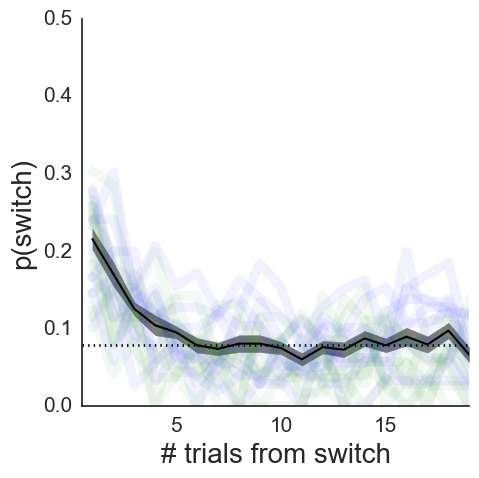

In [13]:
sns.set_style('white')
plt.figure(figsize=(5,5))
for s in range(20):
    if (s%2 == 0):
        plt.plot(np.arange(1,20),p_switchy[s,1:],alpha=0.05,linewidth=7,color='blue')
    else:
        plt.plot(np.arange(1,20),p_switchy[s,1:],alpha=0.05,linewidth=7,color='green')
        
plt.hlines(y=data['Switch'].mean(axis=0),xmin=0,xmax=20,color='black',alpha=1,linewidth=2,linestyles='dotted',label='average')
plt.plot(np.arange(1,20),p_switch[1:],color='black',linewidth=1.5)
plt.fill_between(np.arange(1,20),p_switch[1:]+errors[1:],p_switch[1:]-errors[1:],color='grey')
plt.xlim(0.5,19)
plt.ylim(0,0.5)
plt.xlabel('# trials from switch',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

# Looking more closely at the switch trials

In [14]:
switches = data['Switch'].values

In [15]:
streak = np.array([3,2,1,-1,-2,-3,-4,-5,-6,-7,-8])
port_streaks = np.arange(0,6)
p_switch_a = np.zeros_like(streak)*0.0
p_switch_b = np.zeros_like(streak)*0.0

for i,s in enumerate(streak): 
        p_switch_a[i] = data[(data['Port Streak'] >= 5) & (data['Reward Streak'] == s)]['Switch'].mean()
        p_switch_b[i] = data[(data['Port Streak'] < 5) & (data['Reward Streak'] == s)]['Switch'].mean()

In [16]:
streak = np.array([3,2,1,-1,-2,-3,-4,-5,-6,-7,-8])
port_streaks = np.arange(0,6)
p_switch_indi_a = np.zeros((len(datas),streak.shape[0]))
p_switch_indi_b = np.zeros_like(p_switch_indi_a)

for j,d in enumerate(datas):
    for i,s in enumerate(streak): 
            p_switch_indi_a[j,i] = d[(d['Port Streak'] >= 5) & (d['Reward Streak'] == s)]['Switch'].mean()
            p_switch_indi_b[j,i] = d[(d['Port Streak'] < 5) & (d['Reward Streak'] == s)]['Switch'].mean()

In [17]:
errors_a = np.nanstd(p_switch_indi_a,axis=0) / np.sqrt(p_switch_indi_a.shape[0])
errors_b = np.nanstd(p_switch_indi_b,axis=0) / np.sqrt(p_switch_indi_a.shape[0])

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


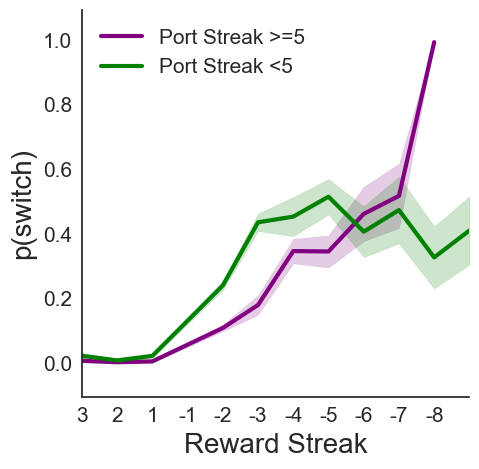

In [18]:
plt.figure(figsize=(5,5))
#plt.vlines(x=0,ymin=0,ymax=1,color='white',linewidth=60,zorder=3)
plt.plot(streak,p_switch_a,label='Port Streak >=5',linewidth=3,zorder=1,color='purple')
plt.fill_between(streak,p_switch_a+errors_a,p_switch_a-errors_a,color='purple',alpha=0.2)
plt.plot(streak,p_switch_b,label='Port Streak <5',linewidth=3,zorder=2,color='green')
plt.fill_between(streak,p_switch_b+errors_b,p_switch_b-errors_b,color='green',alpha=0.2)
plt.xticks(np.arange(3,-8,-1),streak,fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(3,-8)
plt.ylim(-0.1,1.1)
plt.legend(loc='upper left',fontsize=15)
sns.despine()
plt.ylabel('p(switch)',fontsize=20)
plt.xlabel('Reward Streak',fontsize=20)

# Switches when 1_Reward = 0

(0, 0.5)

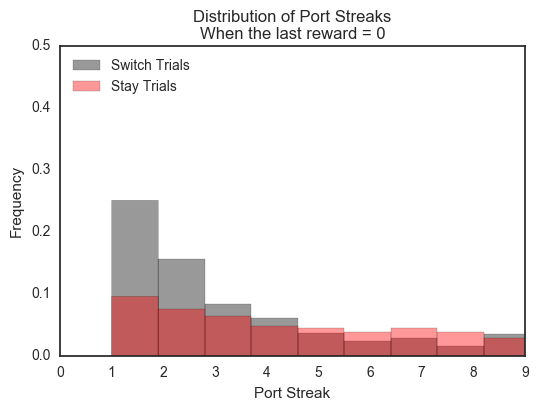

In [19]:
plt.hist(data[(data['1_Reward'] == 0) & (data['Switch'] == 1)]['Port Streak'],color='black',alpha=0.4,normed=True,label='Switch Trials')
plt.hist(data[(data['1_Reward'] == 0) & (data['Switch'] == 0)]['Port Streak'],color='red',alpha=0.4,normed=True,label='Stay Trials')
plt.title('Distribution of Port Streaks\nWhen the last reward = 0')
plt.ylabel('Frequency')
plt.xlabel('Port Streak')
plt.legend(loc='upper left')
plt.xlim(0,9)
plt.ylim(0,0.5)

(array([ 0.07420893,  0.06153912,  0.05397981,  0.04865636,  0.04492994,
         0.04269409,  0.04003237,  0.03864827,  0.03588007,  0.67054214]),
 array([  1. ,   1.9,   2.8,   3.7,   4.6,   5.5,   6.4,   7.3,   8.2,
          9.1,  10. ]),
 <a list of 10 Patch objects>)

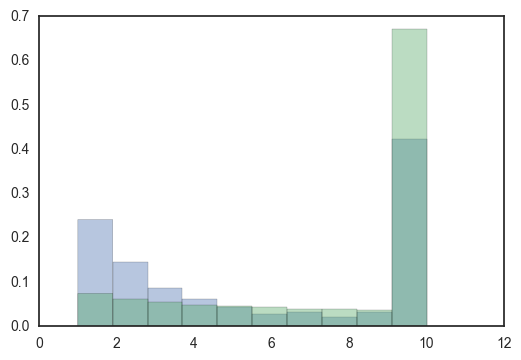

In [20]:
plt.hist(data[data['Switch']==1]['Port Streak'],normed=True,alpha=0.4)
plt.hist(data[data['Switch']==0]['Port Streak'],normed=True,alpha=0.4)

(array([ 0.07420893,  0.06153912,  0.05397981,  0.04865636,  0.04492994,
         0.04269409,  0.04003237,  0.03864827,  0.03588007,  0.67054214]),
 array([  1. ,   1.9,   2.8,   3.7,   4.6,   5.5,   6.4,   7.3,   8.2,
          9.1,  10. ]),
 <a list of 10 Patch objects>)

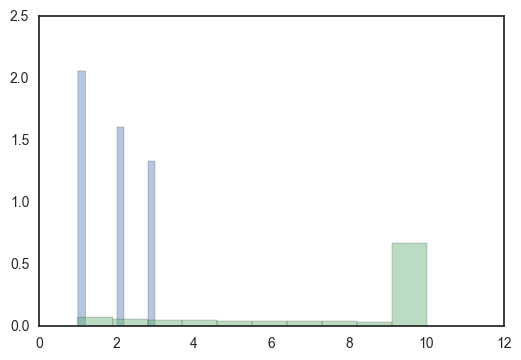

In [21]:
plt.hist(data[data['Port Streak'] <= 3]['Port Streak'],normed=True,alpha=0.4)
plt.hist(data[data['Switch']==0]['Port Streak'],normed=True,alpha=0.4)

In [22]:
data[data['Port Streak'] > 5]['Switch'].mean()

0.052060473055352351

In [23]:
p_switch

array([ 1.        ,  0.21573034,  0.17078652,  0.1258427 ,  0.10449438,
        0.09550562,  0.07865169,  0.0741573 ,  0.08089888,  0.08089888,
        0.0752809 ,  0.06067416,  0.07640449,  0.07303371,  0.08764045,
        0.07865169,  0.08988764,  0.07977528,  0.09775281,  0.06629213])

In [24]:
p_switch = np.zeros(10)*0.0
avg = data['Switch'].mean()

for i,s in enumerate(np.arange(1,11)):
    p_switch[i] = data[data['Port Streak'] == s]['Switch'].mean()

p_switches = np.zeros((20,10))*0.0
p_switches_R = np.zeros((20,10))*0.0
p_switches_nR = np.zeros((20,10))*0.0
for j,d in enumerate(datas):
    for i,s in enumerate(np.arange(1,11)):
        p_switches[j,i] = d[d['Port Streak'] == s]['Switch'].mean()
        p_switches_R[j,i] = d[(d['Port Streak'] == s) & (d['1_Reward']==1)]['Switch'].mean()
        p_switches_nR[j,i] = d[(d['Port Streak'] == s) & (d['1_Reward']==0)]['Switch'].mean()

errors = p_switches.std(axis=0) / np.sqrt(p_switches.shape[0])
errors_R = np.nanstd(p_switches_R,axis=0) / np.sqrt(p_switches.shape[0])
errors_nR = np.nanstd(p_switches_nR,axis=0) / np.sqrt(p_switches.shape[0])
p_switch_R = np.nanmean(p_switches_R,axis=0)
p_switch_nR = np.nanmean(p_switches_nR,axis=0)

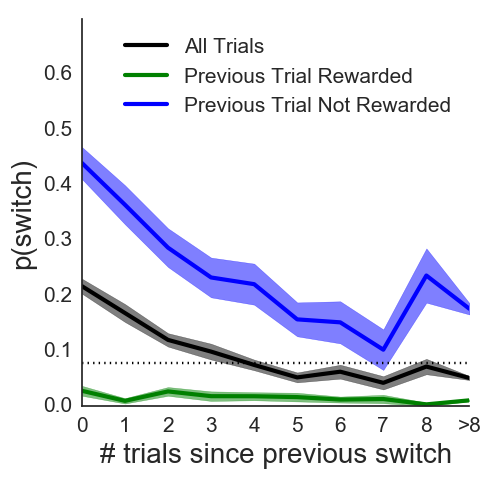

In [25]:
plt.figure(figsize=(5,5))

plt.plot(np.arange(1,11),p_switch,color='black',linewidth=3,label='All Trials')
plt.fill_between(np.arange(1,11),p_switch+errors,p_switch-errors,color='black',alpha=0.5)

plt.plot(np.arange(1,11),p_switch_R,color='green',linewidth=3,label='Previous Trial Rewarded')
plt.fill_between(np.arange(1,11),p_switch_R+errors_R,p_switch_R-errors_R,color='green',alpha=0.5)

plt.plot(np.arange(1,11),p_switch_nR,color='blue',linewidth=3,label='Previous Trial Not Rewarded')
plt.fill_between(np.arange(1,11),p_switch_nR+errors_nR,p_switch_nR-errors_nR,color='blue',alpha=0.5)

plt.hlines(y=avg,xmin=1,xmax=10,linestyle='dotted')
plt.ylim(0,0.7)
plt.ylabel('p(switch)',fontsize=20)
plt.xlabel('# trials since previous switch',fontsize=20)
plt.legend(loc='upper right',fontsize=15)
plt.xticks(np.arange(1,11),[0,1,2,3,4,5,6,7,8,'>8','>9'],fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

In [26]:
c = 0
cs = np.zeros(10)
for j,i in enumerate(np.arange(1,11)):
    c +=  data[data['Port Streak'] == i]['Switch'].sum()/data['Switch'].sum()
    cs[j] = c

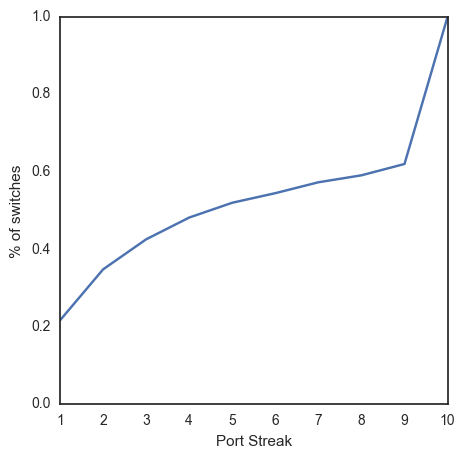

In [27]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11),cs)
plt.ylim(0,1)
plt.ylabel('% of switches')
plt.xlabel('Port Streak')

In [28]:
data.shape

(11326, 50)

In [29]:
t_block_unique = np.unique(data['Block Trial'].values)
p_switch_block = np.zeros((t_block_unique.shape[0],2))
high_p_port = np.zeros_like(p_switch_block)
trial_block_count = np.zeros_like(t_block_unique)

for t in t_block_unique:
    p_switch_block[t,0] = data[data['Block Trial'] == t]['Switch'].mean(axis=0)
    trial_block_count[t] = data[data['Block Trial'] == t].shape[0]
    p_switch_block[t,1] = data[data['Block Trial'] == t]['Switch'].std(axis=0) / np.sqrt(trial_block_count[t])
    
    high_p_port[t,0] = data[data['Block Trial']==t]['Higher p port'].mean(axis=0)
    high_p_port[t,1] = data[data['Block Trial']==t]['Higher p port'].std(axis=0) / np.sqrt(trial_block_count[t])
    

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer w

total # of blocks in dataset: ~152


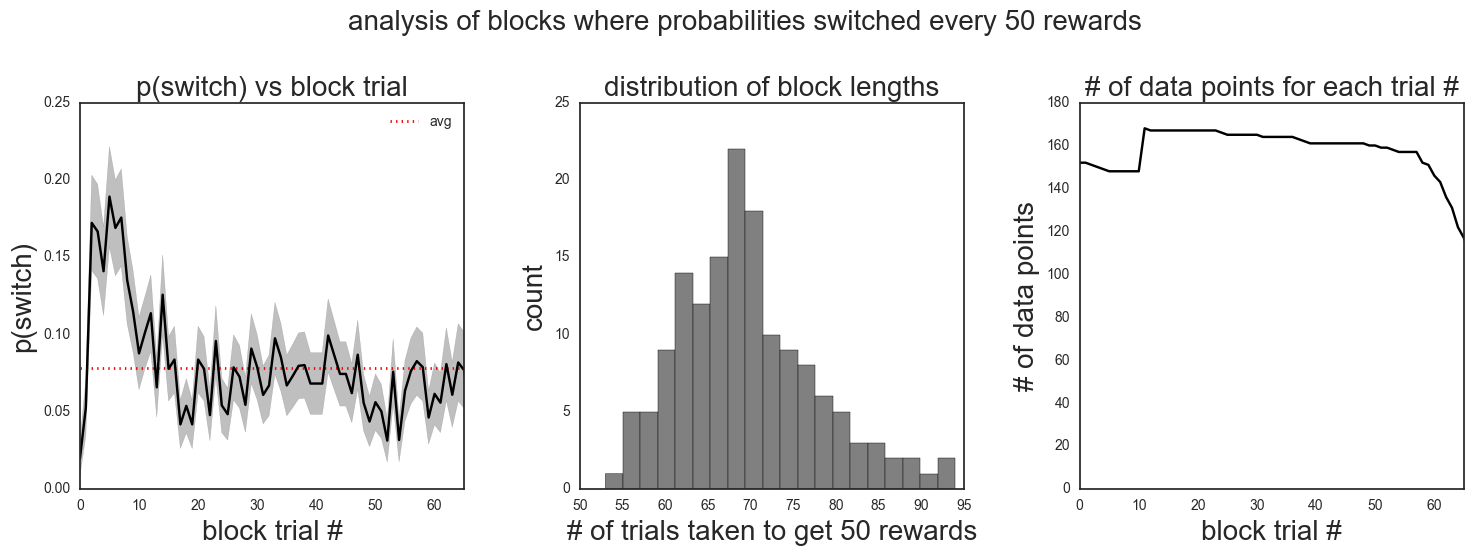

In [30]:
x_end=65
plt.figure(figsize=(15,5))
plt.suptitle('analysis of blocks where probabilities switched every 50 rewards',x=0.5,y=1.1,fontsize=20)

plt.subplot(131)
plt.plot(t_block_unique,p_switch_block[:,0],color='black')
plt.fill_between(t_block_unique,p_switch_block[:,0]+p_switch_block[:,1],p_switch_block[:,0]-p_switch_block[:,1],color='grey',alpha=0.5)
plt.hlines(data['Switch'].mean(axis=0),xmin=0,xmax=x_end,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.legend(loc='upper right')
plt.xlim(0,x_end)
plt.ylim(0,0.25)
plt.xlabel('block trial #',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) vs block trial',fontsize=20)

plt.subplot(132)
plt.hist(data.iloc[np.where(data['Block Trial']==0)[0]-1]['Block Trial'],bins=20,color='grey')
plt.title('distribution of block lengths',fontsize=20)
plt.xlabel('# of trials taken to get 50 rewards',fontsize=20)
plt.ylabel('count',fontsize=20)

plt.subplot(133)
plt.plot(t_block_unique,trial_block_count,color='black')
plt.title('# of data points for each trial #',fontsize=20)
plt.ylabel('# of data points',fontsize=20)
plt.xlabel('block trial #',fontsize=20)
plt.xlim(0,x_end)

plt.tight_layout()
print('total # of blocks in dataset: ~%.0f' % (np.sum(data['Block Trial']==0)))

In [31]:

data.index = np.arange(data.shape[0])

In [32]:
switch_points = data[data['Block Trial'] == 0 ].index.values
switch_points

array([   52,   129,   218,   290,   362,   430,   509,   600,   667,
         731,   803,   875,   946,  1015,  1098,  1209,  1276,  1344,
        1406,  1476,  1554,  1642,  1718,  1845,  1907,  1969,  2023,
        2090,  2167,  2232,  2308,  2397,  2477,  2546,  2627,  2695,
        2774,  2842,  2907,  2991,  3050,  3134,  3192,  3268,  3330,
        3400,  3470,  3532,  3606,  3686,  3750,  3824,  3901,  3988,
        4070,  4148,  4235,  4317,  4391,  4456,  4520,  4581,  4647,
        4767,  4827,  4919,  4991,  5056,  5128,  5199,  5316,  5389,
        5462,  5534,  5605,  5674,  5734,  5803,  5924,  5994,  6076,
        6152,  6223,  6304,  6367,  6424,  6493,  6564,  6632,  6696,
        6766,  6828,  6898,  6954,  7024,  7098,  7164,  7224,  7293,
        7359,  7482,  7549,  7618,  7704,  7776,  7855,  7924,  8051,
        8131,  8200,  8266,  8338,  8413,  8490,  8559,  8667,  8741,
        8807,  8900,  8967,  9062,  9122,  9213,  9280,  9344,  9405,
        9475,  9551,

In [33]:
switch_points = data[data['Block Trial'] == 0 ].index.values

L = 15
paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
paraswitch_port = np.zeros_like(paraswitch)

for i,point in enumerate(switch_points):
    paraswitch[i,:] = data.iloc[point-L:point+L+10]['Switch']
    paraswitch_port[i,:] = data.iloc[point-L:point+L+10]['Higher p port'] 

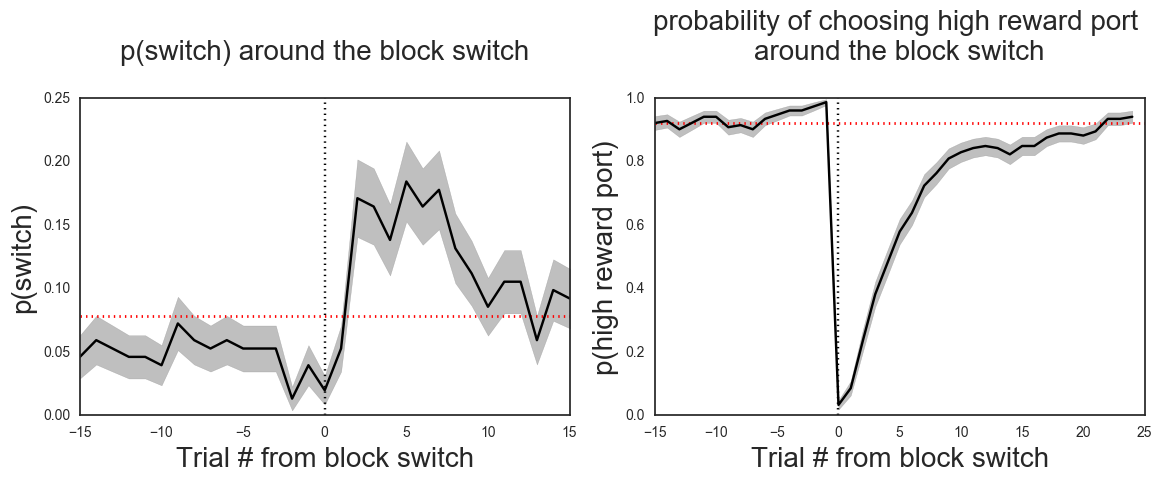

In [34]:
u = paraswitch.mean(axis=0)
s = paraswitch.std(axis=0)
SE = s/np.sqrt(paraswitch.shape[0])
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
plt.hlines(data['Switch'].mean(axis=0),xmin=-1*L,xmax=L+1,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the block switch',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.25)

plt.subplot(122)
u = paraswitch_port.mean(axis=0)
s = paraswitch_port.std(axis=0)
SE = s/np.sqrt(paraswitch.shape[0])
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(0.92,xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(high reward port)',fontsize=20)
plt.title('probability of choosing high reward port \naround the block switch',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L+10)
plt.ylim(0,1)

plt.tight_layout()

(0, 1)

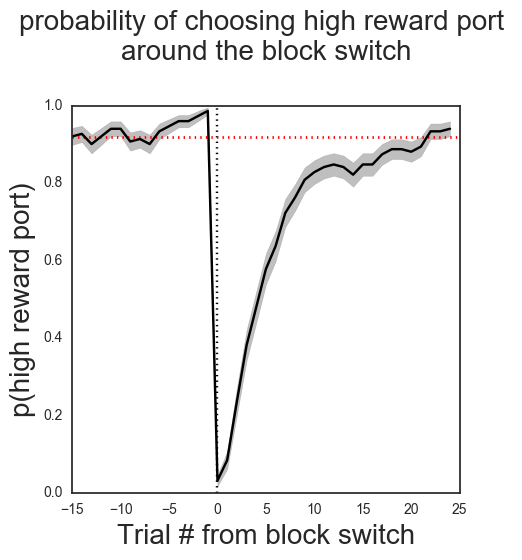

In [35]:
u = paraswitch_port.mean(axis=0)
s = paraswitch_port.std(axis=0)
SE = s/np.sqrt(paraswitch.shape[0])
plt.figure(figsize=(5,5))
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(0.92,xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(high reward port)',fontsize=20)
plt.title('probability of choosing high reward port \naround the block switch',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L+10)
plt.ylim(0,1)

In [36]:
switch_points = data[data['Block Trial'] == 0 ].index.values
switch_points

array([   52,   129,   218,   290,   362,   430,   509,   600,   667,
         731,   803,   875,   946,  1015,  1098,  1209,  1276,  1344,
        1406,  1476,  1554,  1642,  1718,  1845,  1907,  1969,  2023,
        2090,  2167,  2232,  2308,  2397,  2477,  2546,  2627,  2695,
        2774,  2842,  2907,  2991,  3050,  3134,  3192,  3268,  3330,
        3400,  3470,  3532,  3606,  3686,  3750,  3824,  3901,  3988,
        4070,  4148,  4235,  4317,  4391,  4456,  4520,  4581,  4647,
        4767,  4827,  4919,  4991,  5056,  5128,  5199,  5316,  5389,
        5462,  5534,  5605,  5674,  5734,  5803,  5924,  5994,  6076,
        6152,  6223,  6304,  6367,  6424,  6493,  6564,  6632,  6696,
        6766,  6828,  6898,  6954,  7024,  7098,  7164,  7224,  7293,
        7359,  7482,  7549,  7618,  7704,  7776,  7855,  7924,  8051,
        8131,  8200,  8266,  8338,  8413,  8490,  8559,  8667,  8741,
        8807,  8900,  8967,  9062,  9122,  9213,  9280,  9344,  9405,
        9475,  9551,

little note on the for loop below. 

took me little while because I had the order of the else-if statements wrong. 

when block_trial == 0 needs to come BEFORE whether the block trial incremented by 1 or not (which is my hokey way of detecting when a new session started where block_trial does not equal 0. 

I suppose a better way would be to detect when the block trial is 11 AND the previous block trial != 10. that would work. okay. switched it to that now. 

In [145]:
block_reward = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    trial = data.iloc[i]
    
    #lets deal with weird cases first:
    #1) the first row
    if(i == 0):
        block_reward[i] = trial[['10_Reward','9_Reward','8_Reward','7_Reward','6_Reward',
                                '5_Reward','4_Reward','3_Reward','2_Reward','1_Reward','Reward']].sum()
    
    #3) the first trial of a new block
    elif (trial['Block Trial'] == 0):
        block_reward[i] = 0
    
    #2) the first trial of a new session
    elif (((trial['Block Trial'] - trial_prev['Block Trial']) != 1) and (trial['Block Trial'] == 11)):
        block_reward[i] = trial[['10_Reward','9_Reward','8_Reward','7_Reward','6_Reward',
                                '5_Reward','4_Reward','3_Reward','2_Reward','1_Reward','Reward']].sum()
    else:
        block_reward[i] = block_reward[i-1] + trial['Reward']
    
    trial_prev = trial

In [147]:
reward_switches = np.zeros(np.unique(block_reward).shape[0])
for i,r_block in enumerate(np.unique(block_reward)):
    reward_switches[i] = data[block_reward == r_block]['Switch'].mean()

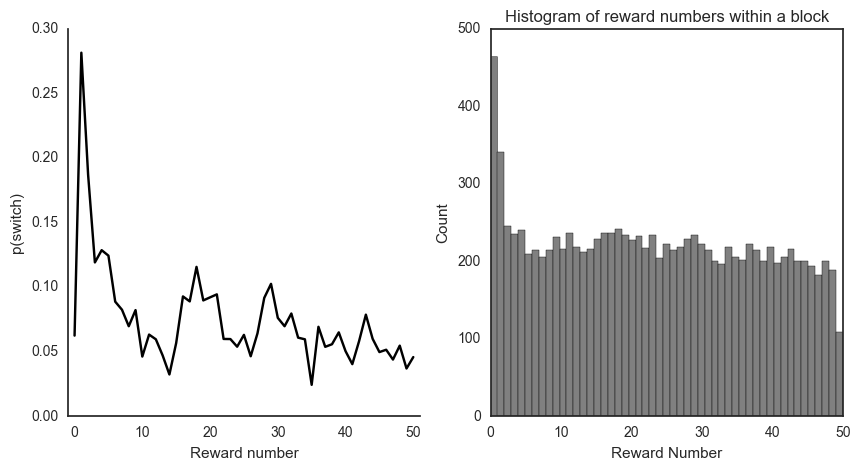

In [158]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.unique(block_reward),reward_switches,color='black')
plt.xlabel('Reward number')
plt.ylabel('p(switch)')
plt.xlim(-1,51)
sns.despine()

plt.subplot(122)
plt.hist(block_reward,bins=51,color='grey')
plt.title('Histogram of reward numbers within a block')
plt.xlabel('Reward Number')
plt.ylabel('Count')